<a href="https://colab.research.google.com/github/AndrewWalker251/bulb_classifier/blob/master/bulb_object_detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Light Bulb Object Detector

One of the challenges with using a classifer to identify different lightbulb types is that the main bulb section is very similar between different connectors. This notebook aims to explore whether an improved identification can be made using by detecting and classifying just the connection.

The dataset is self created and labelled using LabelBox.

References: 
*   https://pytorch.org/docs/stable/torchvision/models.html
*   Notebooks from Global Wheat Detection Kaggle challenge. 


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/My\ Drive/

/content/drive/My Drive


In [3]:
! pip install albumentations==0.4.6

     |████████████████████████████████| 122kB 4.6MB/s 
     |████████████████████████████████| 952kB 14.6MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-cp36-none-any.whl size=65165 sha256=8f9532751b6c2194bd24236d0691fbfd801cccccff359a99c36f0205882ed4ce
  Stored in directory: /root/.cache/pip/wheels/c7/f4/89/56d1bee5c421c36c1a951eeb4adcc32fbb82f5344c086efa14
Successfully built albumentations
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [4]:
import pandas as pd
import numpy as np
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import ast
import torch
import torchvision
import cv2
from torchvision import transforms, datasets
from torchvision.models.detection.faster_rcnn import FasterRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.utils.data import SubsetRandomSampler

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

from torch.utils.data import DataLoader, Dataset

%matplotlib inline

from google.colab.patches import cv2_imshow

In [5]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [6]:
# Labelling completed via LabelBox. 
# Labelbox data needs some format converting to access required data (bounding box and class)
#object_labels = pd.read_csv('lightbulb_data/bulb_labels.csv')
object_labels = pd.read_csv('lightbulb_data/bulb_labels_3_classes.csv')
#IMAGE_DIR = r'lightbulb_data/own_pictures'
IMAGE_DIR = r'lightbulb_data/own_pictures_2'

# remove any images without any annotated objects
object_labels = object_labels[(object_labels['Label']).str.len() > 10]
object_labels.reset_index(inplace=True)

classes = {'b22':1, 'gu10':2, 'e27':3}

# Unest JSON columns
df1 = pd.DataFrame(object_labels['Label'].apply(ast.literal_eval).values.tolist())
df2 = pd.DataFrame(df1['objects'].values.tolist())
df3 = pd.DataFrame(df2[0].values.tolist())
df4 = pd.DataFrame(df3['bbox'].values.tolist())
df = pd.concat([df4, df3['value'] ,object_labels['External ID']],axis=1)
df['value_id'] = df['value'].replace(classes)
df.dropna(inplace=True)
df.reset_index(inplace=True)

In [7]:
df.head()

,index,top,left,height,width,value,External ID,value_id
0,0,1321,1626,779,674,b22,MVIMG_20200911_164611.jpg,1
1,1,1620,1071,933,899,b22,MVIMG_20200911_164636.jpg,1
2,2,1637,1204,625,695,b22,MVIMG_20200911_164706.jpg,1
3,3,1153,1248,440,572,b22,IMG_20200911_164514.jpg,1
4,4,1329,1257,608,669,b22,IMG_20200911_164718.jpg,1


In [8]:
# Modify Pytorch dataset class for object detection 

class BulbDataset(Dataset):

    '''
    Pytorch Dataset Class updated for bulb project
    Methods created to return image and labels.
    '''
    
    def __init__(self, dataframe, image_dir, transforms):
        super().__init__()
        
        '''
        inputs - dataframe: provides data for boxes and labels ['top'	'left'	'height'	'width'	'value'	'External ID'	'value_id']
        image_dir - location where images are saved
        transforms - required transforms for images.    
        '''
        self.image_ids = dataframe['External ID'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms
        
    def __getitem__(self, index):

        '''
        inputs
        index: index of image to be returned
        outputs
        image
        targets - dictionary of boxes, labels and area
        '''
        
        image_id = self.image_ids[index]
        records = self.df[self.df['External ID'] ==image_id]
        image = cv2.imread(f'{self.image_dir}/{image_id}', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /=255.0
        
        # Box coordinates
        boxes = records[['left', 'top','width', 'height']].values
        area = boxes[:,2] * boxes[:,3]
        area = torch.as_tensor(area, dtype=torch.float32)

        # convert to corners of box
        boxes[:,2] = boxes[:,0] + boxes[:,2]
        boxes[:,3] = boxes[:,1] + boxes[:,3]
        
        labels = records['value_id'].values
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['area']= area
        
        if self.transforms:
            sample = {
                'image':image,
                'bboxes':target['boxes'],
                'labels':labels
            }
            sample = self.transforms(**sample)
            image = sample['image']
            target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1,0).float()
            target['labels'] = torch.from_numpy(labels).long()

        return image, target
        
    def __len__(self):
        return self.image_ids.shape[0]
        

In [9]:
# Albumentations library for transfors.
def get_transforms():
    '''
    Uses the albulmentations library to transform images.
    Same transforms used for train and test
    Only uses resize.
    '''
    return A.Compose([
        A.Resize(200, 300),
        ToTensorV2(p=1.0)], bbox_params = {'format':'pascal_voc', 'label_fields': ['labels']})


In [10]:
# Create instance of custom dataset. 
mybulbloader = BulbDataset(df, IMAGE_DIR, get_transforms())

In [11]:
def collate_fn(batch):
  return tuple(zip(*batch))

In [12]:
def create_separate_train_dev_test( dataset, percentages = [0.8,0.1,0.1]):
    '''
    Function to create separate dataloaders for test dev and train.
    
    Inputs - list of percentage breakdowns [train, dev , test] Must add to 1. 
    #TODO Add in test to check for this ~
    
    Outputs - each dataloader.
    '''

    indices = list(range(len(dataset)))
    train_amount =0.8
    dev = 0.1
    test = 0.1

    split_1 = int(np.floor(len(dataset)*0.8))
    split_2 = int(np.floor(len(dataset)*0.9))

    np.random.seed(0)
    np.random.shuffle(indices)

    train_indices, dev_indices, test_indices = indices[:split_1], indices[split_1:split_2],indices[split_2:]

    train_sampler = SubsetRandomSampler(train_indices)
    dev_sampler = SubsetRandomSampler(dev_indices)
    test_sampler = SubsetRandomSampler(test_indices)

    dataloader_train = torch.utils.data.DataLoader(dataset,
                                                 batch_size=2,
                                                 num_workers=0 , sampler = train_sampler, collate_fn = collate_fn)

    dataloader_dev = torch.utils.data.DataLoader(dataset,
                                                 batch_size=2,
                                                 num_workers=0 , sampler = dev_sampler, collate_fn = collate_fn)

    dataloader_test = torch.utils.data.DataLoader(dataset,
                                                 batch_size=2,
                                                 num_workers=0 , sampler = test_sampler,collate_fn = collate_fn)
    
    return dataloader_train, dataloader_dev, dataloader_test

In [13]:
dataloader_train, dataloader_dev, dataloader_test = create_separate_train_dev_test( mybulbloader, percentages = [0.7,0,0.3])

In [14]:
# Visualise output from dataloader.
images, targets = next(iter(dataloader_train))
images = list(image.to(device) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
targets

[{'area': tensor([81104.], device='cuda:0'),
  'boxes': tensor([[228.1250,  62.5661, 250.1488,  80.6878]], device='cuda:0'),
  'labels': tensor([3], device='cuda:0')},
 {'area': tensor([52900.], device='cuda:0'),
  'boxes': tensor([[150.5208, 149.6032, 167.6339, 164.8148]], device='cuda:0'),
  'labels': tensor([2], device='cuda:0')}]

In [15]:
def plot_bulb_and_box(img, objects, idx):
  '''
  Plot image with actual boxes. 

  inputs
  img - batch of images
  objects - actual batch of targets
  idx - index of image in batch
  '''
  
  box = objects[idx]['boxes'].cpu().numpy().astype(np.int32)

  xmin = box[0][0]
  ymin = box[0][1]
  xmax = box[0][2]
  ymax = box[0][3]

  image = img[idx].permute(1,2,0).cpu().numpy()
  fig, ax = plt.subplots(1,1,figsize = (8,4))
  ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color= 'red', linewidth=3))
  for key, value in classes.items(): 
         if value == targets[idx]['labels'].cpu().numpy()[0]: 
             class_label =  key

  ax.text(xmin, ymin, class_label,color='red', fontsize=16)

  ax.imshow(image)
  plt.show()

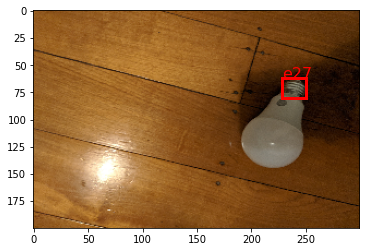

In [16]:
# Plot example of training data
plot_bulb_and_box(images, targets, 0)

In [17]:
# Pytorch pretrained faster RCNN with ResNet50 backbone. 
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


In [18]:
# Correct the head of the model for our domain 
# Retain most of the model as previously trained.
num_classes = 4
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [19]:
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum =0.9, weight_decay=0.0005)

In [20]:
# Training
for epoch in range(1):
  for images, targets in dataloader_train:
    images = list(image.to(device) for image in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

    loss_dict = model(images, targets)
    losses = sum(loss for loss in loss_dict.values())

    optimizer.zero_grad()
    losses.backward()
    optimizer.step()

    print(losses.item())

/usr/local/lib/python3.6/dist-packages/torchvision/ops/boxes.py:101: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  keep = keep.nonzero().squeeze(1)


1.5552890300750732
0.5255400538444519
0.3146176338195801
0.18458379805088043
0.4026278257369995
0.2754437029361725
0.40076956152915955
0.43740028142929077
0.2984949052333832
0.18425427377223969
0.2249189168214798
0.34762704372406006
0.355726420879364
0.2521946132183075
0.3899531960487366
0.30509212613105774
0.3217921257019043
0.3136332333087921
0.27176591753959656
0.23951347172260284
0.28778570890426636
0.2426750510931015
0.20120102167129517
0.224434956908226
0.19615454971790314
0.251481294631958
0.20575836300849915


In [21]:
# Save latest model if required.
PATH = './model_weights.pth'
#torch.save(model.state_dict(), PATH)

In [22]:
# Load last model if not training.
if device.type == 'cpu':
  model.load_state_dict(torch.load(PATH, map_location=torch.device('cpu')))
else:
  model.load_state_dict(torch.load(PATH))

In [23]:
def plot_bulb_and_box_eval(img, objects,actual, idx):
  '''
  Plot image with actual and predicted boxes. 

  inputs
  img - batch of images
  objects - batch of predictions
  actual - batch of actual targets 
  idx - index of image in batch
  '''

  fig, ax = plt.subplots(1,1,figsize = (8,4))

  box = objects[idx]['boxes'].cpu().detach().numpy().astype(np.int32)

  xmin = box[0][0]
  ymin = box[0][1]
  xmax = box[0][2]
  ymax = box[0][3]

  ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color= 'red', linewidth=3))
  
  for key, value in classes.items(): 
         if value == objects[idx]['labels'].cpu().numpy()[0]: 
             class_label =  key + 'predicted'

  ax.text(xmin, ymin, class_label,color='red', fontsize=16)
  
  box = actual[idx]['boxes'].cpu().detach().numpy().astype(np.int32)

  xmin = box[0][0]
  ymin = box[0][1]
  xmax = box[0][2]
  ymax = box[0][3]

  ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color= 'green', linewidth=3))
  
  for key, value in classes.items(): 
         if value == actual[idx]['labels'].cpu().numpy()[0]: 
             class_label =  key + 'actual'

  ax.text(xmax, ymax, class_label,color='green', fontsize=16)

  image = img[idx].permute(1,2,0).cpu().numpy()
  
  
  ax.imshow(image)
  plt.show()

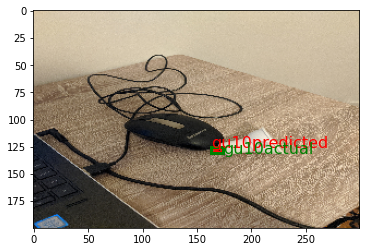

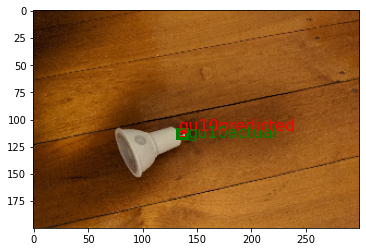

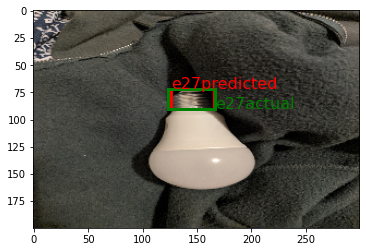

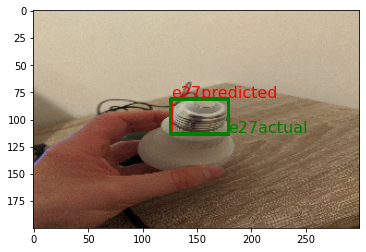

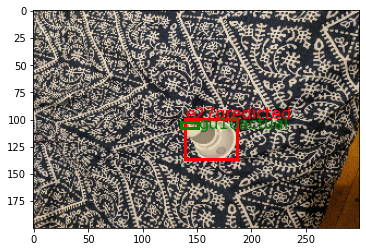

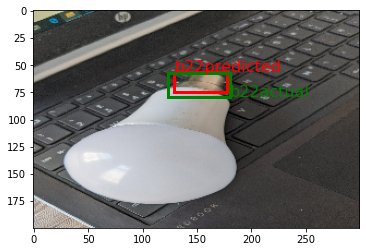

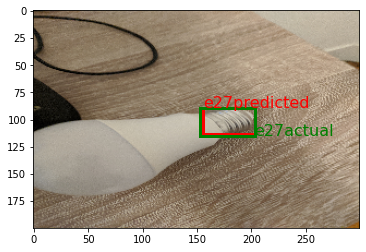

In [24]:
# Predict boxes for all images in test set and plot the results. 
for images, actual in dataloader_test:
  images = list(image.to(device) for image in images)
  actual = [{k: v.to(device) for k, v in t.items()} for t in actual]

  model.eval()
  outputs = model(images)
  outputs = [{k: v.to(device) for k, v in t.items()} for t in outputs]

  for i in range(0,len(outputs)):
    plot_bulb_and_box_eval(images, outputs,actual, i)
